In [1]:
BATCH_SIZE = 1024
#BATCH_SIZE = 2048
#BATCH_SIZE = 512
PAD_SIZE = 80
TARGET_LABELS = ["Solved", "Improvement", "Stacks"]

SEED = 3093453

# Preprocessing

In [2]:
import os

import numpy as np
import pandas as pd
import polars as pl

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(SEED)

tf.random.set_seed(SEED)

sns.set(
    context="talk",
    style="darkgrid"
)

In [3]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [4]:
import tensorflow as tf
from tensorflow import keras

samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["interrupted", "solved"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "validation",
    follow_links = False
)

class_names = np.array(class_names)

Found 199898 files belonging to 2 classes.
Using 159919 files for training.


2023-10-19 21:51:55.680898: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-19 21:51:55.680924: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-19 21:51:55.680927: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-19 21:51:55.681007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-19 21:51:55.681024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 199898 files belonging to 2 classes.
Using 39979 files for validation.


In [5]:
for X,y in train_dataset.take(1):
    pass

In [6]:
#y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
#y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
#y = y == 1
print(y.numpy().mean())

0.34472656


In [7]:
df = pl.DataFrame({"raw": X.numpy().astype(str)})
print(df[0, 0])

dataset: X
instance: RM6
+-----------+
2D Packing MIP with Time Limit 14.352968751782706 [s] in Truck P196390111
Stack 0 with items: ['0090038200_14062023000909', '0090038200_14062023010979', '0090038200_14062023024237']
Stack 1 with items: ['0090038200_14062023023840', '0090038200_14062023022988', '0090038200_14062023022988']
Stack 2 with items: ['0090038200_14062023022988', '0090038200_14062023022988', '0090038200_14062023022988']
Stack 3 with items: ['0090038200_14062023022988', '0090038200_14062023022988', '0090038200_14062023022988']
Stack 4 with items: ['0090038200_14062023010501', '0090038200_14062023007575', '0090038200_14062023004958']
Stack 5 with items: ['0090038200_14062023007575', '0090038200_14062023004958', '0090038200_14062023004958']
Stack 6 with items: ['0090038200_14062023004958', '0090038200_14062023004958', '0090038200_14062023004958']
Stack 7 with items: ['0090038200_14062023004958', '0090038200_14062023004958', '0090038200_14062023004958']
Stack 8 with items: ['0

# Loading CSVs

In [8]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
26743100,null,90016900,"""169GB-10""","""8200658549""","""SLI---2112""",1.206,1.01,0.285,0.03433,0.0,"""C""","""BY""","""0090016900_270…",false,false,0.285
2695000,null,90016900,"""GRF1""","""271002239R""","""ECM---6655""",2.4,1.2,0.76,0.243,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.715
679301,null,90016900,"""169GB-20""","""8200689547""","""MTEM--4632""",1.8,1.2,2.34,0.550536,0.045,"""C""","""BY""","""0090016900_270…",false,false,2.295
679301,null,90016900,"""169GB-20""","""8200665427""","""MTEM--4462""",2.4,1.2,1.62,0.457104,0.045,"""C""","""BY""","""0090016900_270…",false,false,1.575
3043102,null,90016900,"""169GD-60""","""8200689884""","""SLI---1101""",1.9,1.2,0.75,0.271,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.705


In [9]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .unique()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
)
truck_stops.collect().head()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62059600,1,null,1,"""X0""",1,"""P187721701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730401""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730403""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730405""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730407""","""A""","""AS"""


In [10]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Length", "Width", "Max weight",
             ]

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .unique()
    .rename({"Id truck": "truck_id", "Max weight": "Weight"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
)

truck_dims = truck_dims.with_columns([
    (pl.col("Length") / 1000),
    (pl.col("Width") / 1000),
    (pl.col("Weight") / 1000),
])

truck_dims.collect().head()

truck_id,Length,Width,Weight,dataset,instance
str,f64,f64,f64,str,str
"""P187721701""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730401""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730403""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730405""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730407""",14.94,2.5,24.0,"""A""","""AS"""


In [11]:
import sys
sys.path.append("..")

from utils.preprocessing import extract_raw_data, explode_instances_into_stacks, explode_stacks_into_items
from utils.preprocessing import join_items, group_items_by_stack, join_truck_loading_order, append_truck_info

In [12]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    .pipe(append_truck_info, truck_dims)
    .collect()
    .to_numpy()
)

X

array([[0, 1.2, 1.0, ..., False, '1-1-1', False],
       [0, 1.6, 1.2, ..., False, '1-1-1', False],
       [0, 1.6, 1.2, ..., False, '1-1-1', False],
       ...,
       [1023, 1.2, 1.0, ..., False, '1-1-6', False],
       [1023, 1.2, 1.0, ..., False, '1-1-6', False],
       [1023, 13.5, 2.44, ..., False, '0-0-0', True]], dtype=object)

In [13]:
def get_tensor_representation(X, packing_clm=6):
    
    indices = np.unique(X[:, 0])
    indices = np.sort(indices)

    # (batch_size, ?, features)
    X = np.array([X[X[:,0] == idx] for idx in indices], dtype = "object")

    # replace the packing order with the stop index (i.e 1-1-1 and 1-1-2 turn to 0 and 1, respectively)
    #packing_clm = min([i for i, clm in enumerate(df.columns) if clm == "packing_order"])
    
    for i, x in enumerate(X):
        packing_order = x[:,packing_clm]
        stops = np.unique(packing_order)
        stops = np.sort(stops)
        stops = {stop: j for j, stop in enumerate(stops)}
        stops = [stops[order] for order in packing_order]
        X[i][:,packing_clm] = stops

    # pad the variable length number of stacks into fixed
    #  (batch_size, pad_size, features)
    X = tf.keras.utils.pad_sequences(X, maxlen=PAD_SIZE, padding = "post", dtype="float64")
    # drop the index column (batch_size, pad_len, n_features)
    X = X[:,:,1:].astype(float)
    return X

c = get_tensor_representation(X)
c.shape

(1024, 80, 7)

In [14]:
c[1, :, :].round(3)

array([[ 1.6  ,  1.2  ,  0.6  ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.6  ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.6  ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.6  ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.6  ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.3  ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.2  ,  0.629,  0.   ,  0.   ,  1.   ,  0.   ],
       [ 1.6  ,  1.19 ,  0.54 ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.19 ,  0.54 ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.19 ,  0.54 ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.19 ,  0.54 ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.19 ,  0.54 ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.19 ,  0.54 ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.19 ,  0.54 ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.6  ,  1.19 ,  0.27 ,  0.   ,  0.   ,  2.   ,  0.   ],
       [ 1.2  ,  1.   ,  

In [15]:
def get_additional_labels(df: pl.DataFrame) -> dict[str: np.array]:
    """
    """

    pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
    mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

    # mip_improvements: pl.Series[list[str]]
    # with entries according to the pattern, i.e all MIP improvement rows
    
    y_num_improvements = mip_improvements.list.len()-1
    
    y_improvement = y_num_improvements > 0

    y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)

    y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)

    y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)


    # missing stacks:
    y_stack_not_included = np.zeros((len(df), PAD_SIZE), dtype=float)
    pattern = "Stack (\d*) not in final solution with items:"
    x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
    
    for i, missing_stacks in enumerate(x):
        for j in missing_stacks:
            y_stack_not_included[i, j] +=1


    y = [
        #y_num_improvements.to_numpy(),
        y_improvement.to_numpy().astype(int),
        #y_packed_area_ratio.to_numpy(),
        #y_packed_area.to_numpy(),
        #y_last_update.to_numpy(),
        y_stack_not_included
    ]
    
    return y

#pattern = "Stack (\d*) not in final solution with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
#x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])

In [16]:
y_stack_not_included = np.zeros((BATCH_SIZE, PAD_SIZE), dtype=float)
pattern = "Stack (\d*) not in final solution with items:"
x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
    
for i, missing_stacks in enumerate(x):
    for j in missing_stacks:
        y_stack_not_included[i, j] +=1

y_stack_not_included.mean()

0.01561279296875

In [17]:
def polars_transformation(X_batch, y_batch) -> (np.array, np.array):
    """

    Returns:
    --------
    X: np.array[float32]
        3D Feature Tensor of shape (Batch_size, Pad_size, n_features=7)

        - Batch_size: Truck Optimization Instances
        - Pad_size: Stacks (or Trucks), padded up to create tensors
        - n_features: Length, Width, Weight, L/W Forced Orientation
                      packing order, is_truck
    """
    
    df = pl.DataFrame({"raw": X_batch.numpy().astype(str)})
    
    X = (
        df.lazy()
        .pipe(extract_raw_data)
        .pipe(explode_instances_into_stacks)
        .pipe(explode_stacks_into_items)
        .pipe(join_items, items)
        .pipe(group_items_by_stack)
        .pipe(join_truck_loading_order, truck_stops)
        .pipe(append_truck_info, truck_dims)
        .collect()
        .to_numpy()
    )

    X = get_tensor_representation(X)

    y_batch = y_batch.numpy()
    y_batch = [y_batch]
    y_extra = get_additional_labels(df)
    y_batch += y_extra

    
    return X, y_batch

#polars_transformation(X)

In [18]:
print(df[0,0])

dataset: X
instance: RM6
+-----------+
2D Packing MIP with Time Limit 14.352968751782706 [s] in Truck P196390111
Stack 0 with items: ['0090038200_14062023000909', '0090038200_14062023010979', '0090038200_14062023024237']
Stack 1 with items: ['0090038200_14062023023840', '0090038200_14062023022988', '0090038200_14062023022988']
Stack 2 with items: ['0090038200_14062023022988', '0090038200_14062023022988', '0090038200_14062023022988']
Stack 3 with items: ['0090038200_14062023022988', '0090038200_14062023022988', '0090038200_14062023022988']
Stack 4 with items: ['0090038200_14062023010501', '0090038200_14062023007575', '0090038200_14062023004958']
Stack 5 with items: ['0090038200_14062023007575', '0090038200_14062023004958', '0090038200_14062023004958']
Stack 6 with items: ['0090038200_14062023004958', '0090038200_14062023004958', '0090038200_14062023004958']
Stack 7 with items: ['0090038200_14062023004958', '0090038200_14062023004958', '0090038200_14062023004958']
Stack 8 with items: ['0

# DNN

## Hyperparameters:

In [19]:
N_FEATURES = c.shape[-1]

# number of encoder blocks
n_blocks = 3 #6
num_heads = 4
key_dim = int(N_FEATURES/num_heads)
use_bias = True # If true the convergence seems to be much faster/sooner. But with false, it picks up pace later
## Encoder dropout in total and per layer
total_encoder_dropout = 0.3
encoder_dropout = 1-(1-total_encoder_dropout)**(1/n_blocks)
print(f"Encoder Layer Dropout of {encoder_dropout:.1%} resulting in a total Dropout of {total_encoder_dropout:.1%} over {n_blocks} encoders")


# number of fully connected layers with droput
#fully_connected_units = [] # [16]
#fully_connected_dropout_rate = 0.5

# activation function
activation = "gelu" # "relu" "gelu" "selu" "swish"




# Learning Rate
initial_lr = 10e-3 # 10e-3
lr_decay = 0.8 # 0.9

# Optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = initial_lr)
#optimizer = keras.optimizers.SGD(learning_rate=1e-3)

# Loss Function
#loss_fn = tf.keras.losses.BinaryCrossentropy(name="binary_crossentropy",)

# Focal Loss gamma:

loss_solved = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=2,
    alpha = 1-y.numpy().mean(),
    name='solved_focal_loss'
)

loss_improvement = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    alpha = 0.56,
    name='improvement_focal_loss'
)


loss_stacks = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=6,
    alpha = y_stack_not_included.mean(),
    name='stacks_focal_loss'
)


Encoder Layer Dropout of 11.2% resulting in a total Dropout of 30.0% over 3 encoders


In [20]:
loss_objects = [
    loss_solved,
    loss_improvement,
    loss_stacks
]

In [21]:
mean_losses = [tf.keras.metrics.Mean(name=target) for target in TARGET_LABELS]

In [22]:
all_metrics: list[list[tf.keras.metrics]] = [
    [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
    [
        tf.keras.metrics.Precision(name = "PRC"),
        tf.keras.metrics.Recall(name = "SNS"),
        tf.keras.metrics.AUC(curve='PR', name="AUC"),
        tf.keras.metrics.BinaryAccuracy(name = "ACC")
    ],
]

## Architecture

In [23]:
from tensorflow.keras.layers import Masking, BatchNormalization, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Add, Dense, Input, Reshape, Permute, Lambda

from utils.DNN.model_layers import TransformerEncoder

#help(Masking)
#help(MultiHeadAttention)
#help(Reshape)
#help(Dropout)
#help(Lambda)

In [24]:
# build a model using the functional API:
from keras import backend as K

from tensorflow.keras import Model


# Input
input_layer = Input(shape=(PAD_SIZE, N_FEATURES))

# Masking padded input
masking_layer = Masking(
    mask_value=0,
    input_shape=(PAD_SIZE, N_FEATURES),
    dtype=tf.float16, # float, # tf.float16
    name="MaskingLayer"
)
x = masking_layer(input_layer)

#batch_norm_layer = BatchNormalization(name="BatchNormalizationLayer")
#x = batch_norm_layer(masking_layer)


# Encoder Block
for i in range(1, n_blocks+1):
    # Self attention with add and layer norm
    self_attention_layer = TransformerEncoder(
        num_heads=num_heads, key_dim=key_dim,
        dropout=encoder_dropout,               # Hyperparameter
        use_bias=use_bias,                     # usually False, but technically Hyperparameter
        idx = i,
        activation=activation,
        units = N_FEATURES,
        use_PreLN=True
    )
    x = self_attention_layer(
        x
    )

reshape = Lambda(lambda x: tf.squeeze(x), name="Output")

# Pipe Attention directly into missing stack prediction:

output_stacks = Dense(1, activation='sigmoid', name = "PredictionStacks")
xx = output_stacks(x)
output_stacks = reshape(xx)



# After Attention, reduce to single dimension
add_across_dim = Lambda(
    lambda x: K.sum(x, axis=1)/PAD_SIZE**1,
    output_shape=lambda s: (s[0], s[2]),
    name = "ReduceViaSum"
)

x = add_across_dim(x)


# Fully Connected Layer + Droput
#for i, units in enumerate(fully_connected_units):
#    
#    full_connected_layer = Dense(units=units, activation=activation,name=f"FullyConnectedLayer-{i+1}")
#    x = full_connected_layer(x)
#
#    dropout_layer = Dropout(fully_connected_dropout_rate,
#                            name = f"FullyConnectedDropoutLayer-{i+1}")
#    x = dropout_layer(x)





full_connected_layer = Dense(units=N_FEATURES, activation=activation,name=f"FullyConnectedLayerSolved")
xx = full_connected_layer(x)
output_solved = Dense(1, activation='sigmoid', name = "PredictionSolved")
xx = output_solved(xx)
output_solved = reshape(xx)



full_connected_layer = Dense(units=N_FEATURES, activation=activation,name=f"FullyConnectedLayerImprovement")
xx = full_connected_layer(x)
output_improvement = Dense(1, activation='sigmoid', name = "PredictionImprovement")
xx = output_improvement(xx)
output_improvement = reshape(xx)


outputs = [output_solved, output_improvement, output_stacks]

model = Model(
    inputs=input_layer,
    #outputs=x,
    outputs=outputs,
)

In [25]:
model(c)

[<tf.Tensor: shape=(1024,), dtype=float32, numpy=
 array([0.52290475, 0.5366261 , 0.52668715, ..., 0.5353112 , 0.5312527 ,
        0.5393665 ], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=
 array([0.58763933, 0.5829916 , 0.6097365 , ..., 0.6099229 , 0.5954212 ,
        0.5709062 ], dtype=float32)>,
 <tf.Tensor: shape=(1024, 80), dtype=float32, numpy=
 array([[0.5333237 , 0.67733103, 0.7320158 , ..., 0.91702247, 0.91702247,
         0.91702247],
        [0.8601863 , 0.8601863 , 0.8601863 , ..., 0.9101057 , 0.9101057 ,
         0.9101057 ],
        [0.77661836, 0.77661836, 0.778874  , ..., 0.91646194, 0.91646194,
         0.91646194],
        ...,
        [0.6482522 , 0.6493087 , 0.65265423, ..., 0.9202092 , 0.9202092 ,
         0.9202092 ],
        [0.72450256, 0.72450256, 0.72319996, ..., 0.9153754 , 0.9153754 ,
         0.9153754 ],
        [0.8343409 , 0.8343409 , 0.8343409 , ..., 0.9172918 , 0.9172918 ,
         0.9172918 ]], dtype=float32)>]

In [26]:
_ = model(c) # just check if it works
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 7)]              0         []                            
                                                                                                  
 MaskingLayer (Masking)      (None, 80, 7)                0         ['input_1[0][0]']             
                                                                                                  
 transformer_encoder (Trans  (None, 80, 7)                201       ['MaskingLayer[0][0]']        
 formerEncoder)                                                                                   
                                                                                                  
 transformer_encoder_1 (Tra  (None, 80, 7)                201       ['transformer_encoder[0][0

## Training Process Functions

In [27]:
def geometric_decay(epoch: int, initial_lr:float=10e-3, lr_decay:float=0.9) -> float:
    """
    Exponential decay learning rate schedule
    """
    return initial_lr * lr_decay**lr_decay

In [28]:
def print_status_bar(iteration, total, losses, all_metrics=None, training:bool=True):
    
    metrics = "\t\t\t\t\t\t\t\t\t".join([f"{TARGET_LABELS[i]:<12}\tLoss: {losses[i].result():.4f}" + "\t".join([f"{m.name:>10}: {m.result():.2%}" for m in metrics])
                                         for i, metrics in enumerate(all_metrics)])
    
    if training:
        prefix="Training"
    else:
        prefix="Validation"
    
    print(f"\r{prefix}-Iteration: {iteration+1:0>3}/{total:<1000}" + metrics,
          end="")


In [29]:
@tf.function
def model_pass(inputs, targets, training):
    """
    Usual Tensorflow model passing of inputs throught the network.
    If in training mode, the optimizier can apply the gradients
    observed with GradientTape to the model parameters
    """
    
    with tf.GradientTape() as tape:
        
        outputs = model(inputs, training=training)
        losses = [l(t, o) for l,o,t in zip(loss_objects, outputs, targets)]
        
        if training:
            gradients = tape.gradient(losses, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        for i, mean_loss in enumerate(mean_losses):
            mean_loss(losses[i])
        
    return outputs


In [30]:
def run_epoch(dataset, all_metrics:list[list[tf.keras.metrics]], epoch:int, history:pd.DataFrame, training:bool=True):
    """
    Single epoch, running several training steps over a dataset
    """

    for step, (X_batch, y_batch) in enumerate(dataset):
        
        X_batch, y_batch = polars_transformation(X_batch, y_batch)
        
        outputs = model_pass(X_batch, y_batch, training=training)
        #mean_loss(loss)
        
        for i, metrics in enumerate(all_metrics):
            for metric in metrics:
                metric(y_batch[i].reshape(-1), outputs[i].numpy().reshape(-1))
    
        print_status_bar(step, len(dataset), mean_losses, all_metrics, training=training)

    print("\n")
    
    for i, metrics in enumerate(all_metrics):
        for metric in metrics:
            data = pd.DataFrame({
                "Epoch": [epoch],
                "Target": [TARGET_LABELS[i]],
                "Metric": [metric.name if training else f"Val-"+metric.name],
                "Value": [float(metric.result())],
            })
            history = pd.concat([history, data])
            metric.reset_states()

    for i, mean_loss in enumerate(mean_losses):
        data = pd.DataFrame({
            "Epoch": [epoch],
            "Target": [TARGET_LABELS[i]],
            "Metric": ["Loss" if training else f"Val-"+"Loss"],
            "Value": [float(mean_loss.result())],
        })
        history = pd.concat([history, data])
        mean_loss.reset_states()
            
    return history

## Model Training

In [31]:
n_epochs = 3
n_steps = len(train_dataset) // BATCH_SIZE

clms = ["Epoch", "Target", "Metric", "Value"]
history = pd.DataFrame(columns = clms)


for epoch in range(1, n_epochs + 1):
    
    print(f"Epoch {epoch:0>3}/{ n_epochs:0>3}")

    history = run_epoch(train_dataset, all_metrics, epoch=epoch, history=history, training=True)
    history = run_epoch(val_dataset, all_metrics, epoch=epoch, history=history, training=False)

    print("-"*120)

Epoch 001/003


2023-10-19 21:52:12.631972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training-Iteration: 157/157                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_23821/4137319759.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, data])


Validation-Iteration: 040/40                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [32]:
history = history.pivot_table(values = ["Value"], columns=["Metric"], index=["Epoch", "Target"]).reset_index().set_index("Epoch", drop=True)
clms = history.columns
history.columns = [clm[i>=1] for i, clm in enumerate(clms)]
history

,Target,ACC,AUC,Loss,PRC,SNS,Val-ACC,Val-AUC,Val-Loss,Val-PRC,Val-SNS
Epoch,,,,,,,,,,,
1,Improvement,0.603168,0.541362,0.232459,0.577873,0.260856,0.656220,0.612900,0.219361,0.605934,0.559405
1,Solved,0.768877,0.740161,0.128177,0.766817,0.502841,0.801371,0.800753,0.116238,0.825048,0.568668
1,Stacks,0.951949,0.035802,0.012539,0.024831,0.053159,0.980323,0.047204,0.001938,0.040580,0.010797
2,Improvement,0.667776,0.639575,0.216503,0.625641,0.551904,0.680957,0.648384,0.213573,0.626305,0.628468
2,Solved,0.806783,0.808718,0.112384,0.836592,0.567371,0.813377,0.826057,0.108113,0.867792,0.567973
2,Stacks,0.980174,0.075951,0.001669,0.130613,0.044570,0.979110,0.102091,0.001487,0.170454,0.083075
3,Improvement,0.688486,0.670119,0.210632,0.652955,0.576707,0.692288,0.691532,0.206816,0.663656,0.567716
3,Solved,0.811329,0.822439,0.108152,0.829209,0.591079,0.814378,0.830168,0.106581,0.854122,0.583959
3,Stacks,0.979241,0.099506,0.001489,0.161257,0.074015,0.978020,0.099614,0.001477,0.158792,0.090787


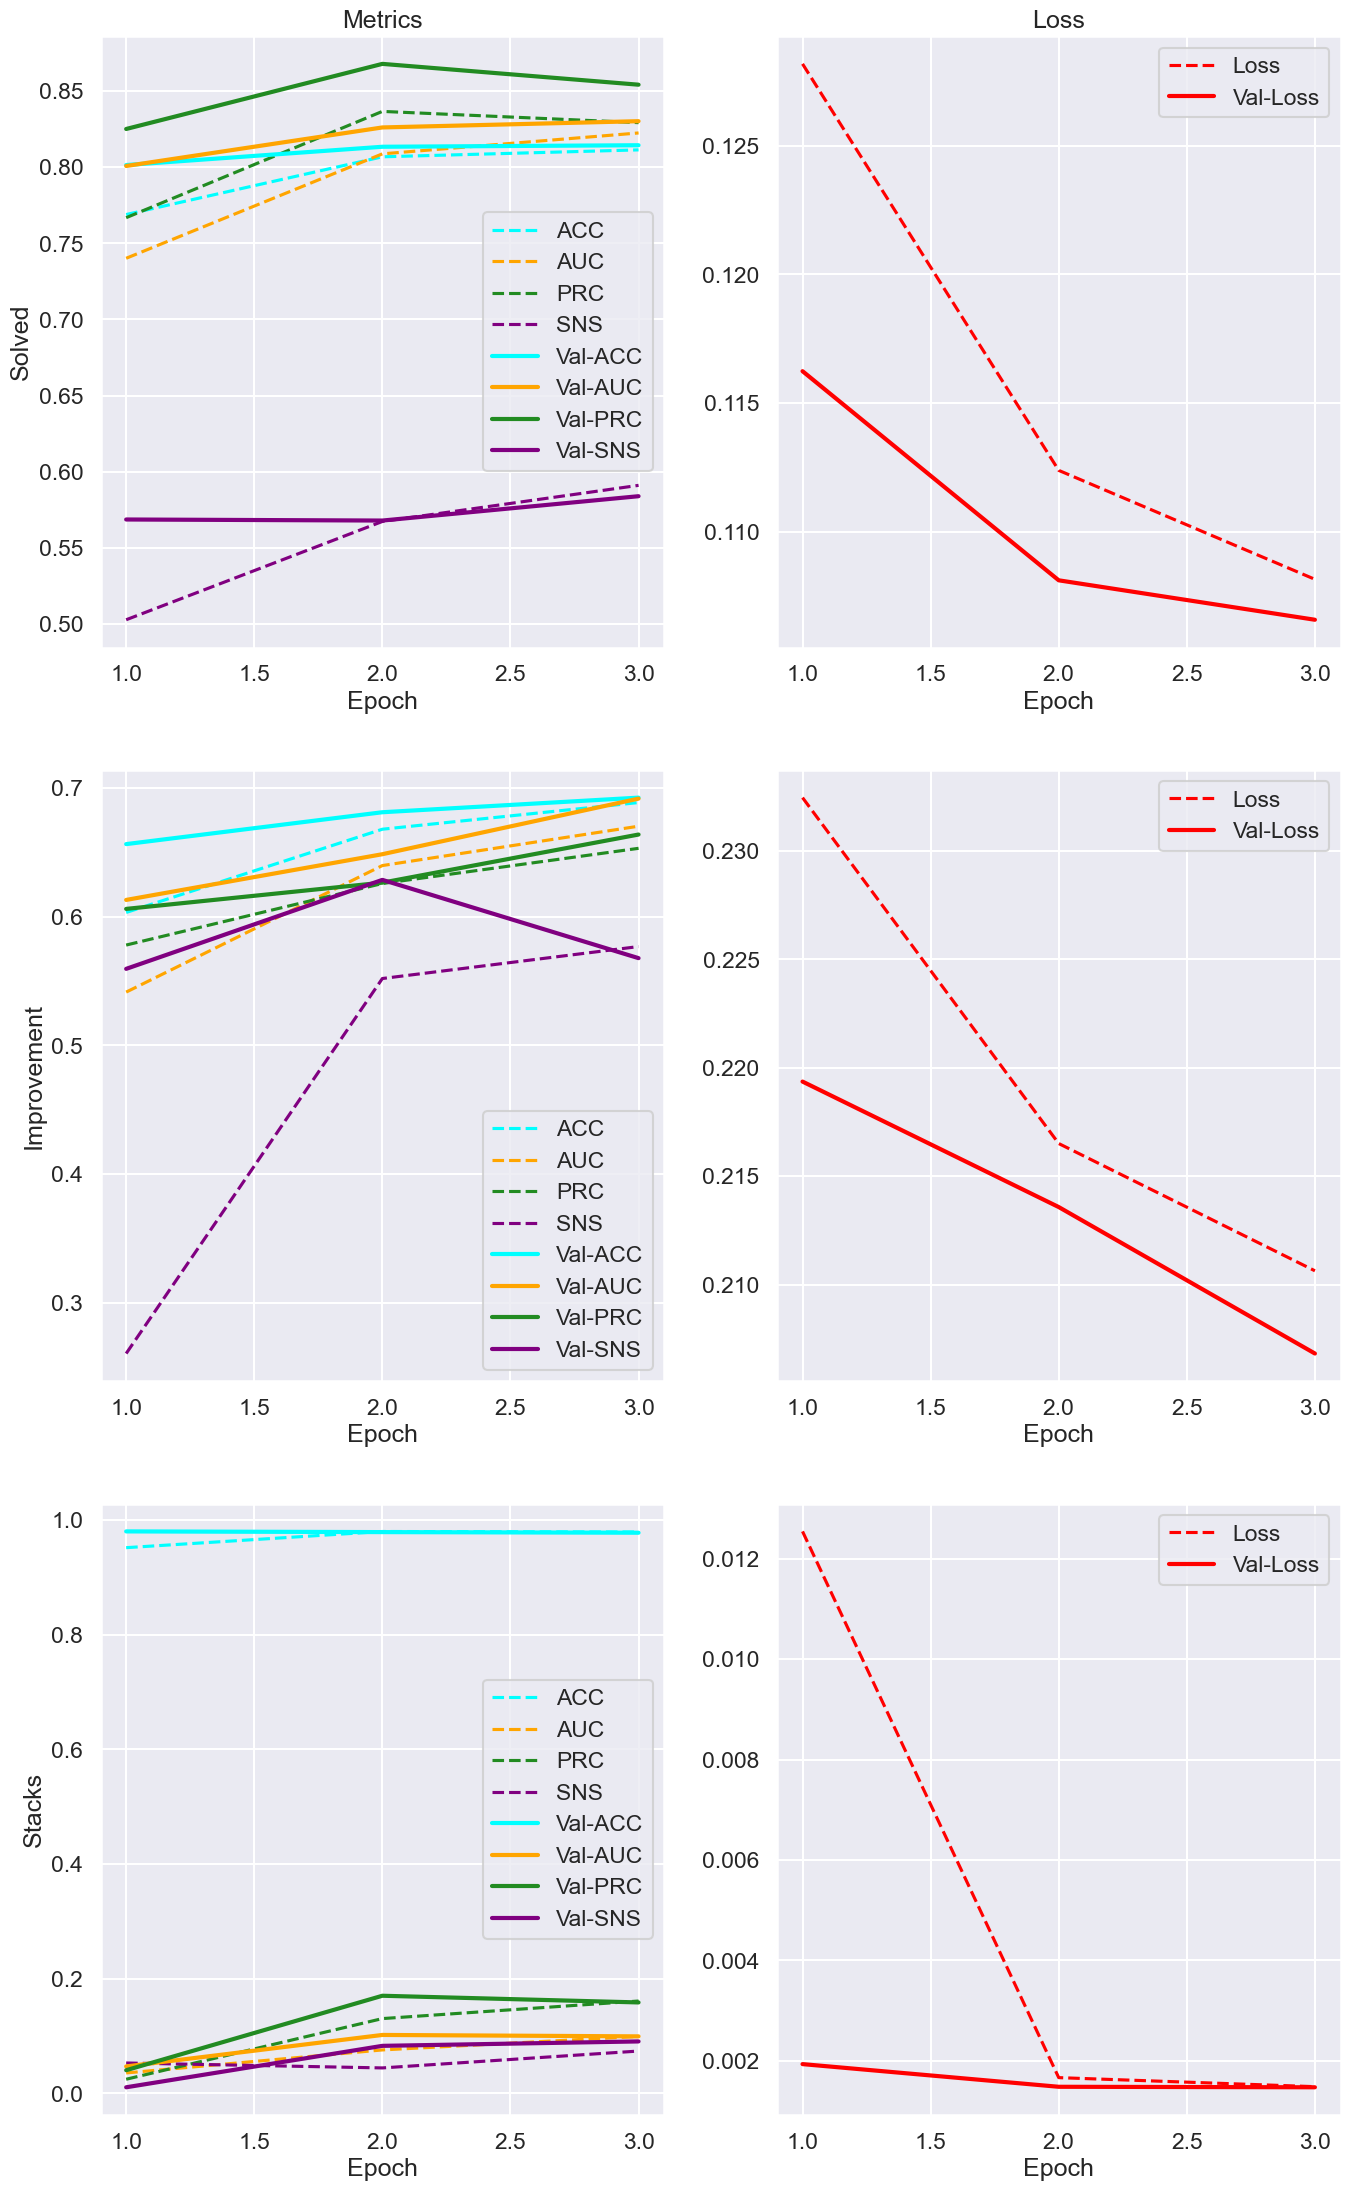

In [33]:
clms = history.columns

fig, ax = plt.subplots(len(TARGET_LABELS), 2, figsize=(16, 9*len(TARGET_LABELS)))

colors = ["cyan", "orange", "forestgreen", "purple"]

for i, target in enumerate(TARGET_LABELS):
    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], ls = "--", color = colors, label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(~clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 0], lw = 3, color = colors, label = "Validation")
    ax[i, 0].set(ylabel = target)

    history.loc[(history.Target == target), (~clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], ls = "--", color = "red", label = "Training")
    history.loc[(history.Target == target), (clms.str.contains("Val-"))&(clms.str.contains("Loss"))]\
        .plot(ax=ax[i, 1], lw = 3, color = "red", label = "Validation")
    #ax[i, 1].set(ylabel = target)

ax[0, 0].set(title="Metrics")
ax[0, 1].set(title="Loss");


Tradeoff between Sensitivity and Precision can be seen very good here.
Most likely explanation:
- the bias of the final layer before the sigmoid has changed drastically.
- if the bias increases, predicted probabilities increase. This means more found solved cases and higher Sensitivity
- if the bias decreases, predicted probabilities decrease. This means less found solved cases, only the more certain cases. Higher Precision

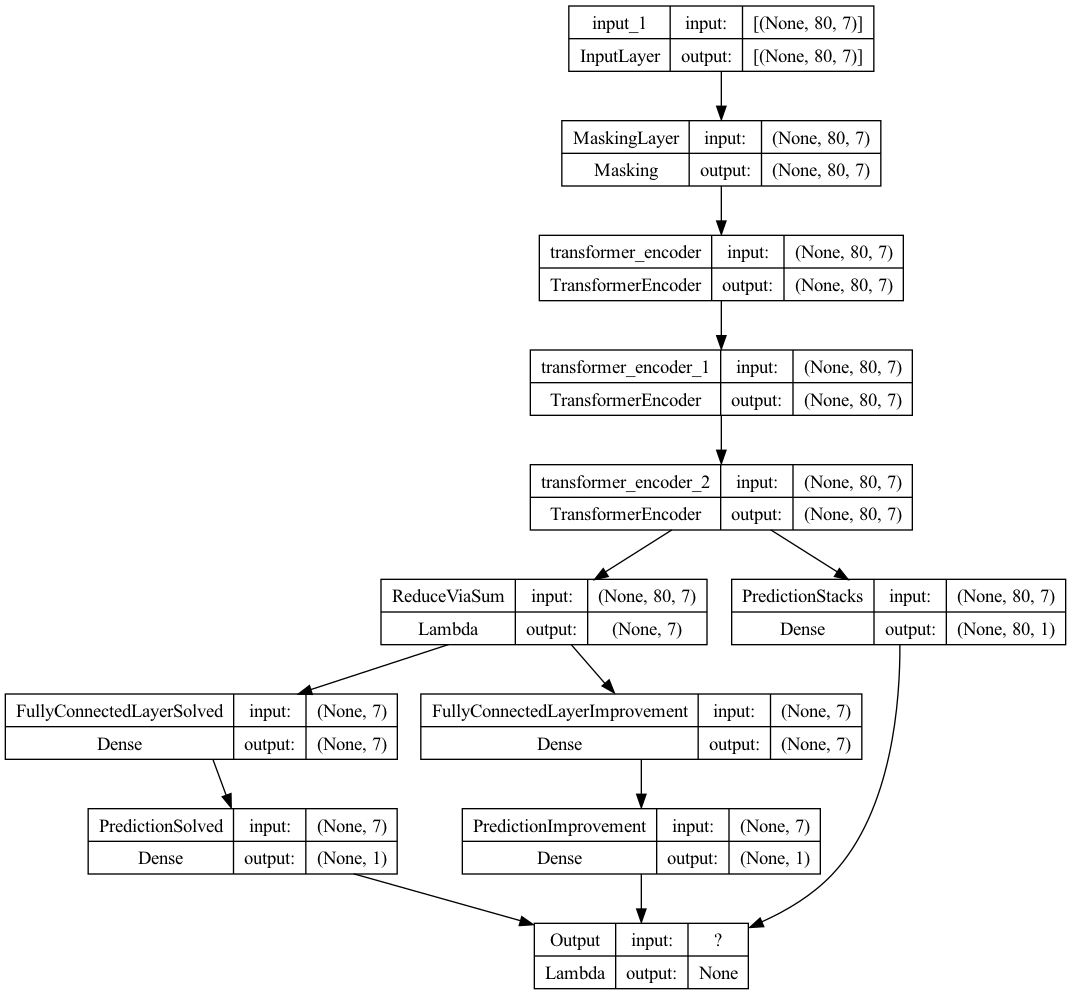

In [34]:
tf.keras.utils.plot_model(
    model,
    #to_file,
    show_shapes=True
)